# visualization

> Necessary scripts to visualize orbits

In [15]:
#| default_exp visualize

In [16]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [17]:
from orbit_generation_testing.reader import get_example_mat_data

In [18]:
mat_data= get_example_mat_data()
mat_data.shape

(200, 6, 300)

In [19]:
#| export
mu = 0.0122
two_body_problem_points={
    'Moon': (1-mu,0,0),
    'Earth': (-mu,0,0),
    'Lagrange 1': (0.8369,0,0),
    'Lagrange 2': (1.1557,0,0)
}

# Static

In [20]:
#| export
def visualize_static_orbits(data, time_instants=None, orbit_indices=None, point_dict=two_body_problem_points, show_legend=False):
    """
    Visualizes orbits and optionally highlights specified time instants for every orbit in orbit_indices with data shape (num_orbits, 6, num_time_points).
    Optionally includes named points in the visualization.

    :param data: numpy.ndarray, shape (num_orbits, 6, num_time_points), containing orbit data.
    :param time_instants: Optional[list[int]], time instants to highlight across selected orbits. If None, no highlights are made.
    :param orbit_indices: Optional[list], indices of the orbits to visualize and highlight. If None, uses all orbits.
    :param show_legend: Optional[bool], indicates whether to show the legend.
    :param point_dict: Optional[dict], keys are point names and values are 3D coordinates of the points.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    if orbit_indices is None:
        orbit_indices = range(data.shape[0])
    if time_instants is None:
        time_instants = []  # This ensures the for loop over time_instants does not raise an error

    # Validate time instants, if any
    if time_instants:  # This will only execute if time_instants is not empty
        max_time_instants = data.shape[2]
        for time_instant in time_instants:
            if time_instant < 0 or time_instant >= max_time_instants:
                raise ValueError(f"Time instant {time_instant} is out of range.")

    # Plot all requested orbits
    for index in orbit_indices:
        if index < 0 or index >= data.shape[0]:
            print(f"Orbit index {index} is out of range.")
            continue

        X = data[index, 0, :]  # X coordinates
        Y = data[index, 1, :]  # Y coordinates
        Z = data[index, 2, :]  # Z coordinates
        ax.plot(X, Y, Z, label=f'Orbit {index}', alpha=0.5)

        # Highlight the specified time instants for each orbit, if any
        for time_instant in time_instants:
            posx, posy, posz = data[index, 0:3, time_instant]
            ax.scatter(posx, posy, posz, color='red', s=100, zorder=5)

    # Add points from point_dict if provided
    if point_dict is not None:
        for point_name, coords in point_dict.items():
            ax.scatter(*coords, label=point_name, s=100, zorder=5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Orbits Static Visualization')

    if show_legend:
        ax.legend()

    plt.show()



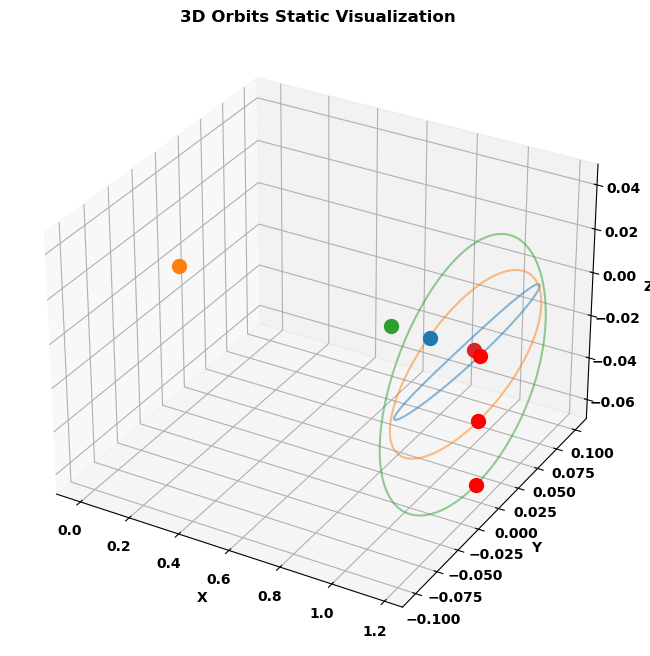

In [21]:
visualize_static_orbits(data= mat_data,time_instants=[0], orbit_indices=[0,20,40])

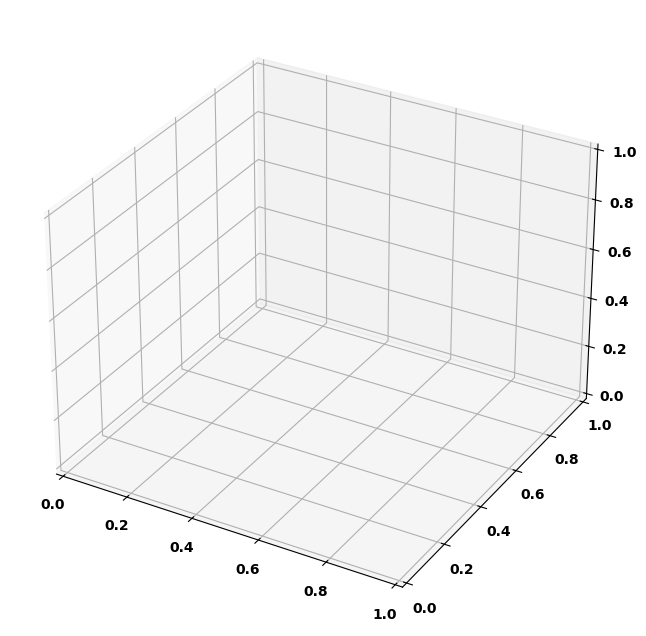

In [22]:
#| test "invalid time_instants raises ValueError"
from pytest import raises
time_instants = [-1, 11]  # Out of bounds
with raises(ValueError):
    visualize_static_orbits(mat_data, time_instants)

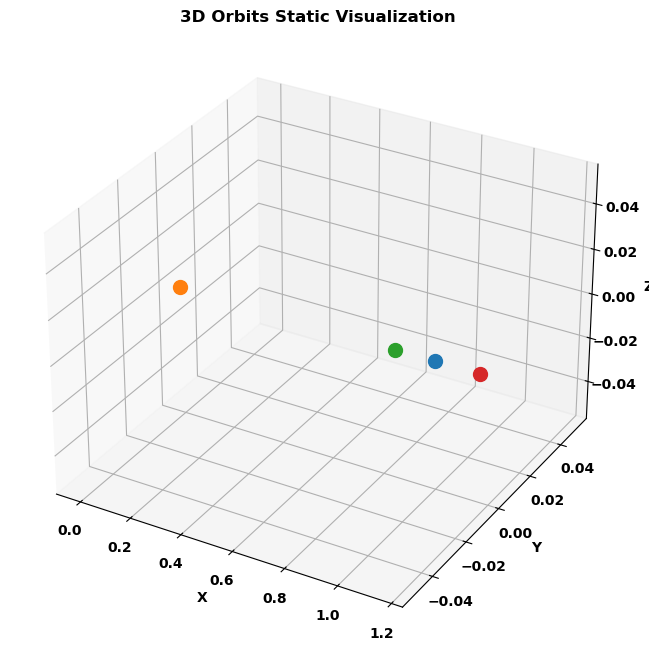

In [23]:
#| test "invalid orbit_indices prints warning"
from unittest.mock import patch
time_instants = [0, 9]  # Valid
orbit_indices = [201]  # Out of bounds
with patch("builtins.print") as mock_print:
    visualize_static_orbits(mat_data, time_instants, orbit_indices)
    mock_print.assert_called()

# Dynamic

In [24]:
#| export
def export_dynamic_orbits_html(data, orbit_indices=None, point_dict=two_body_problem_points, time_instants=None, filename='orbits.html'):
    """
    Visualize orbits in 3D and save as an interactive HTML file with a clickable legend, for data organized as (num_orbits, 6, num_time_points).
    Includes the option to add named points to the visualization and optionally highlights the positions of each orbit at given time_instants.

    :param data: Numpy array of shape (num_orbits, 6, num_time_points)
    :param orbit_indices: Optional; List of indices of the orbits to visualize
    :param point_dict: Optional; Dictionary where keys are point names and values are the 3D coordinates of the points
    :param time_instants: Optional; List of int, the time instants to highlight across all orbits.
    :param filename: String, name of the file to save the HTML plot
    """
    num_orbits = data.shape[0]  # Adjusted for the new data shape
    if orbit_indices is None:
        orbit_indices = range(num_orbits)  # Default to all orbits
    if time_instants is None:
        time_instants = []  # Default to no specific time instants

    fig = go.Figure()

    # Validate the provided time_instants, if any
    for timestamp in time_instants:
        if timestamp < 0 or timestamp >= data.shape[2]:
            raise ValueError(f"The provided timestamp {timestamp} is out of range.")

    # Plot each orbit
    for index in orbit_indices:
        if index < 0 or index >= num_orbits:
            print(f"Orbit index {index} is out of range.")
            continue

        X = data[index, 0, :]  # X coordinates
        Y = data[index, 1, :]  # Y coordinates
        Z = data[index, 2, :]  # Z coordinates

        fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='lines',
                                   name=f'Orbit {index}',
                                   legendgroup=f'orbit{index}',
                                   showlegend=True))

        # Highlight the positions at the given time_instants, if any
        for timestamp in time_instants:
            highlight_x = [data[index, 0, timestamp]]
            highlight_y = [data[index, 1, timestamp]]
            highlight_z = [data[index, 2, timestamp]]
            fig.add_trace(go.Scatter3d(x=highlight_x, y=highlight_y, z=highlight_z, mode='markers',
                                       marker=dict(size=5, color='red'),
                                       name=f'Highlight {index} @ {timestamp}',
                                       legendgroup=f'orbit{index}',
                                       showlegend=False))

    # Add points from the point_dict if provided
    if point_dict is not None:
        for point_name, coords in point_dict.items():
            fig.add_trace(go.Scatter3d(x=[coords[0]], y=[coords[1]], z=[coords[2]], mode='markers',
                                       marker=dict(size=5),
                                       name=point_name))

    fig.update_layout(title='3D Orbits Visualization',
                      scene=dict(xaxis_title='X',
                                 yaxis_title='Y',
                                 zaxis_title='Z'),
                      width=800, height=600,
                      legend_title="Orbits Legend",
                      clickmode='event+select')

    fig.write_html(filename)
    print(f"Visualization saved to {filename}")




In [25]:
export_dynamic_orbits_html(data=mat_data, point_dict= two_body_problem_points, time_instants=[0], orbit_indices=[1,2,3,4,5])

Visualization saved to orbits.html


In [26]:
#| test "export dynamic orbits without error"
data = np.random.rand(5, 6, 50)  
orbit_indices = [0, 1, 2]  
time_instants = [10, 20, 30] 
filename = "test_orbits.html"  
point_dict = {"Earth": (0, 0, 0), "Mars": (1, 2, 1.5)}

export_dynamic_orbits_html(data, orbit_indices, point_dict, time_instants, filename)

assert os.path.isfile(filename), "File was not created"

os.remove(filename)

Visualization saved to test_orbits.html


In [27]:
#| hide
import nbdev; nbdev.nbdev_export()